# SureChEMBL Tutorial

## An introduction to patent chemoinformatics using SureChEMBL data and RDKit

### myChEMBL team, ChEMBL group, EMBL-EBI.

### Outline:
1. Read a file that contains small molecule antimalarials reported in US patents in 2010. The file was downloaded from [SureChEMBL](https://www.surechembl.org).
2. Filter by different text-mining and chemoinformatics properties to remove noise and enrich the genuinely novel structures claimed in the patent document. 
3. Visualise the chemical space using MDS and dimensionality reduction.
4. Find the MCS of the claimed compounds in each patent.
5. Compare the derived MCS with the actual Markush structure as reported in the original patent document.

In [1]:
%matplotlib inline
%pylab inline
import pandas as pd

from IPython.display import display
from IPython.display import display_pretty, display_html, HTML, Javascript

from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFMCS as MCS
from rdkit.Chem import Draw
Draw.DrawingOptions.elemDict[0]=(0.,0.,0.)  # draw dummy atoms in black

from itertools import cycle
from sklearn import manifold
from scipy.spatial.distance import *

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

# Get the base URL of the VM:
display(Javascript('IPython.notebook.kernel.execute("current_url = " + "\'"+document.URL+"\'");'))

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

In [2]:
base_url = 'localhost:8000' if (current_url.split('http://')[1].split('/')[0] == 'localhost:9612') else current_url.split('http://')[1].split(':')[0]
base_url

'tannin.windows.ebi.ac.uk'

In [3]:
pd.options.display.mpl_style = 'default'

In [4]:
rcParams['figure.figsize'] = 16,10

## 1. Read and filter the input file

The file was manually collated by extracting all chemistry from a list of patent documents in [SureChEMBL](https://www.surechembl.org). The Lucene query used to retrieve the list of relevant patents was: "ic:C07D AND ic:A61P003306 AND pnctry:US AND pdyear:2010 AND (ttl:\*malaria\* OR ab:\*malaria\* OR ttl:\*parasit\*)"

In [5]:
df = pd.read_csv('US_antimalarial_patents_cmpds.txt',sep='\t')

Let's check the contents:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 9359
Data columns (total 28 columns):
SCPN                         9360 non-null object
annotation_reference         9360 non-null object
chemical_id                  9360 non-null int64
smiles                       9360 non-null object
type                         9360 non-null object
chemical_document_count      9360 non-null int64
annotation_document_count    3724 non-null float64
title_count                  3724 non-null float64
abstract_count               3724 non-null float64
claims_count                 3724 non-null float64
description_count            3724 non-null float64
chemical_corpus_count        9360 non-null int64
annotation_corpus_count      3724 non-null float64
molecular_weight             9360 non-null float64
med_chem_alert               9360 non-null int64
log_p                        9360 non-null float64
donor_count                  9360 non-null int64
acceptor_count               9360 non-nu

In [7]:
df.head()

,SCPN,annotation_reference,chemical_id,smiles,type,chemical_document_count,annotation_document_count,title_count,abstract_count,claims_count,...,ring_count,rotatable_bond_count,radical,fragment,connected,singleton,simple,lipinski,lead_likeness,bio_availability
0,US-20100305056-A1,pyridine,14400966,C1=CN=C=C=C1,TEXT,8,8,0,0,4,...,1,0,0,0,1,0,0,1,1,1
1,US-20100305056-A1,pyridine,15128234,C1=NC=C=C=C1,TEXT,8,8,0,0,4,...,1,0,0,0,1,0,0,1,1,1
2,US-20100305056-A1,pyridine n-oxide,1316,[O-][N+]1=CC=CC=C1,TEXT,8,6,0,0,3,...,1,0,0,0,1,0,0,1,1,1
3,US-20100305056-A1,pyridine n-oxide,1317,CN(C)C(=O)OC1=CC=C[N+](C)=C1,TEXT,6,6,0,0,3,...,1,2,0,0,1,0,0,1,1,1
4,US-20100305056-A1,methyl sulfone,19382,C[S](C)(=O)=O,TEXT,5,2,0,0,1,...,0,0,0,0,1,0,0,1,1,1


In [8]:
df.shape

(9360, 28)

In [9]:
df['chemical_id'] = df['chemical_id'].map(lambda x: 'SCHEMBL{0}'.format(x))

**First round of filtering: Novel compounds appear in the description or claims section of the document. Alternatively, they are extracted from images or mol files**

In [10]:
dff = df[(df['claims_count'] > 0) | (df['description_count'] > 0) | (df['type'] != "TEXT")]

In [11]:
dff.shape

(9357, 28)

**Second round of filtering: Simple physicochemical properties and counts**

In [12]:
dff = dff[(dff['rotatable_bond_count'] < 15) & (dff['ring_count'] > 0) & (df['radical'] == 0) & (df['singleton'] == 0) & (df['simple'] == 0)]

In [13]:
dff.shape

(7463, 28)

In [14]:
dff = dff[(dff['molecular_weight'] >= 300) & (dff['molecular_weight'] <= 800) & (dff['log_p'] > 0) & (dff['log_p'] < 6)]

In [15]:
dff.shape

(2477, 28)

In [16]:
dff = dff[(dff['chemical_corpus_count'] < 400) & ((dff['annotation_corpus_count'] < 400) | (dff['annotation_corpus_count'].isnull()))]

In [17]:
dff.shape

(1823, 28)

**Convert SMILES to RDKit molecules**

In [18]:
PandasTools.AddMoleculeColumnToFrame(dff, smilesCol = 'smiles')

**Third round of filtering: Remove salts and duplicates, based on InChI keys**

In [19]:
PandasTools.RemoveSaltsFromFrame(dff)

In [20]:
dff['InChI'] = dff['ROMol'].map(Chem.MolToInchi)

In [21]:
dff['InChIKey'] = dff['InChI'].map(Chem.InchiToInchiKey)

,SCPN,annotation_reference,chemical_id,smiles,type,chemical_document_count,annotation_document_count,title_count,abstract_count,claims_count,description_count,chemical_corpus_count,annotation_corpus_count,molecular_weight,med_chem_alert,log_p,donor_count,acceptor_count,ring_count,rotatable_bond_count,radical,fragment,connected,singleton,simple,lipinski,lead_likeness,bio_availability,ROMol,InChI,InChIKey
17,US-20100305056-A1,"(2s)-4,4-dichloro-n-[(1s)-1-cyano-2-(4-cyano-2-fluorophenyl)ethyl]-2-({(1s)-2,2,2-trifluoro-1-[4'-(methylsulfonyl)biphenyl-4-yl]ethyl}amino)butanamide",SCHEMBL2926034,CS(=O)(=O)C1=CC=C(C=C1)C1=CC=C(C=C1)[C@H](N[C@@H](CC(Cl)Cl)C(=O)N[C@@H](CC1=C(F)C=C(C=C1)C#N)C#N)C(F)(F)F,TEXT,8,4,0,0,1,3,15,4,655.489990,1,5.24907,2,6,3,12,0,0,1,0,0,0,0,0,,"InChI=1S/C29H24Cl2F4N4O3S/c1-43(41,42)23-10-8-19(9-11-23)18-4-6-20(7-5-18)27(29(33,34)35)39-25(14-26(30)31)28(40)38-22(16-37)13-21-3-2-17(15-36)12-24(21)32/h2-12,22,25-27,39H,13-14H2,1H3,(H,38,40)/t22-,25-,27-/m0/s1",LZTBOSYPPJMQEC-LNBJVWSJSA-N
18,US-20100305056-A1,"n-[(1s)-1-cyano-2-(4-cyanophenyl)ethyl]-4-fluoro-n2-{(1s)-2,2,2-trifluoro-1-[4'-(methylsulfonyl)biphenyl-4-yl]ethyl}-l-leucinamide",SCHEMBL3765601,CC(C)(F)C[C@H](N[C@@H](C1=CC=C(C=C1)C1=CC=C(C=C1)S(C)(=O)=O)C(F)(F)F)C(=O)N[C@@H](CC1=CC=C(C=C1)C#N)C#N,TEXT,2,2,0,0,1,1,6,2,614.653992,0,4.71589,2,6,3,12,0,0,1,0,0,0,0,0,,"InChI=1S/C31H30F4N4O3S/c1-30(2,32)17-27(29(40)38-25(19-37)16-20-4-6-21(18-36)7-5-20)39-28(31(33,34)35)24-10-8-22(9-11-24)23-12-14-26(15-13-23)43(3,41)42/h4-15,25,27-28,39H,16-17H2,1-3H3,(H,38,40)/t25-,27-,28-/m0/s1",VPYOLBXPKYHWDV-MYKRZTLLSA-N
19,US-20100305056-A1,"n-[(1s)-1-cyano-2-(4-cyanophenyl)ethyl]-4-fluoro-n2-{(1s)-2,2,2-trifluoro-1-[4'-(methylsulfonyl)biphenyl-4-yl]ethyl}-l-leucinamide",SCHEMBL3765606,CC(C)(F)C[C@H](N([C@@H](CC1=CC=C(C=C1)C#N)C#N)[C@@H](C1=CC=C(C=C1)C1=CC=C(C=C1)S(C)(=O)=O)C(F)(F)F)C(N)=O,TEXT,2,2,0,0,1,1,2,2,614.653992,0,4.87526,1,6,3,12,0,0,1,0,0,0,0,0,,"InChI=1S/C31H30F4N4O3S/c1-30(2,32)17-27(29(38)40)39(25(19-37)16-20-4-6-21(18-36)7-5-20)28(31(33,34)35)24-10-8-22(9-11-24)23-12-14-26(15-13-23)43(3,41)42/h4-15,25,27-28H,16-17H2,1-3H3,(H2,38,40)/t25-,27-,28-/m0/s1",CMTCBOOMXFLKRD-MYKRZTLLSA-N
20,US-20100305056-A1,"n-[(1s)-1-cyano-2-(4-cyano-2-fluorophenyl)ethyl]-4-fluoro-n2-{(1s)-2,2,2-trifluoro-1-[4'-(methylsulfonyl)biphenyl-4-yl]ethyl}-l-leucinamide",SCHEMBL2927657,CC(C)(F)C[C@H](N([C@@H](CC1=CC=C(C=C1F)C#N)C#N)[C@@H](C1=CC=C(C=C1)C1=CC=C(C=C1)S(C)(=O)=O)C(F)(F)F)C(N)=O,TEXT,2,2,0,0,1,1,4,2,632.643982,0,5.01796,1,6,3,12,0,0,1,0,0,0,0,0,,"InChI=1S/C31H29F5N4O3S/c1-30(2,33)16-27(29(39)41)40(24(18-38)15-23-5-4-19(17-37)14-26(23)32)28(31(34,35)36)22-8-6-20(7-9-22)21-10-12-25(13-11-21)44(3,42)43/h4-14,24,27-28H,15-16H2,1-3H3,(H2,39,41)/t24-,27-,28-/m0/s1",JNOWJQKPSZTASP-WIRXVTQYSA-N
21,US-20100305056-A1,"n-[(1s)-1-cyano-2-(4-cyano-2-fluorophenyl)ethyl]-4-fluoro-n2-{(1s)-2,2,2-trifluoro-1-[4'-(methylsulfonyl)biphenyl-4-yl]ethyl}-l-leucinamide",SCHEMBL3765380,CC(C)(F)C[C@H](N[C@@H](C1=CC=C(C=C1)C1=CC=C(C=C1)S(C)(=O)=O)C(F)(F)F)C(=O)N[C@@H](CC1=CC=C(C=C1F)C#N)C#N,TEXT,8,2,0,0,1,1,11,2,632.643982,0,4.68843,2,6,3,12,0,0,1,0,0,0,0,0,,"InChI=1S/C31H29F5N4O3S/c1-30(2,33)16-27(29(41)39-24(18-38)15-23-5-4-19(17-37)14-26(23)32)40-28(31(34,35)36)22-8-6-20(7-9-22)21-10-12-25(13-11-21)44(3,42)43/h4-14,24,27-28,40H,15-16H2,1-3H3,(H,39,41)/t24-,27-,28-/m0/s1",RGJONKKMBWPLQS-WIRXVTQYSA-N

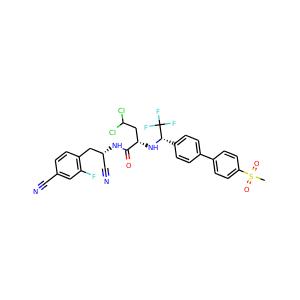
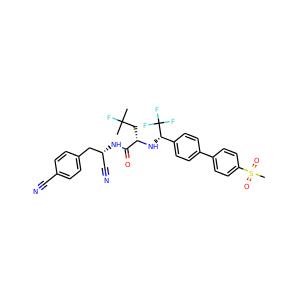
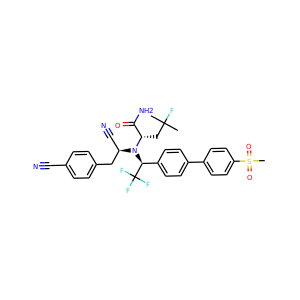
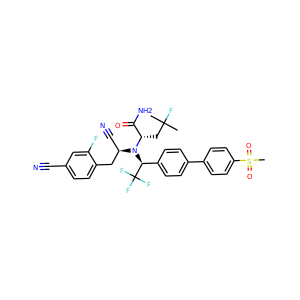
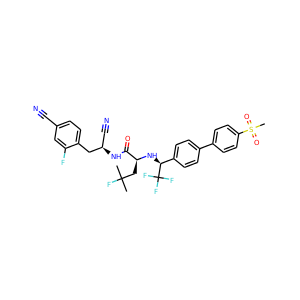

In [22]:
dff.head()

In [23]:
dff = dff.drop_duplicates(['SCPN','InChIKey'])

In [24]:
dff.shape

(845, 31)

Wow, that was a lot of duplicates. This is because in US patents a compound may come from 3 different sources: text, image and mol file. 

In [25]:
dff = dff.ix[[d.count('.') < 2 for d in dff['smiles']]]

In [26]:
dff.shape

(843, 31)

**Fourth round of filtering: Remove Boron-containing compounds as they are likely to be reactants.**

In [27]:
dff = dff.ix[~(dff['ROMol'] >= Chem.MolFromSmiles('B'))]

In [28]:
dff.shape

(840, 31)

**Fifth round of filtering: Remove patents with less than 10 compounds**

In [29]:
dff_counts = dff[['SCPN','ROMol']].groupby('SCPN').count()

In [30]:
tokeep = list(dff_counts.ix[dff_counts.ROMol >= 10].index)

In [31]:
dff = dff.ix[dff.SCPN.isin(tokeep)]

In [32]:
dff.shape

(807, 31)

OK, filtering is over. Let's prepare a summary table of the remaining patent documents and their compounds:

In [33]:
dff_counts = dff[['SCPN','ROMol']].groupby('SCPN').count()

In [34]:
dff_counts['Link'] = dff_counts.index.map(lambda x: '<a href="https://www.surechembl.org/document/{0}/" target="_blank">{0}</a>'.format(x))

In [35]:
dff_counts = dff_counts.rename(columns={'ROMol':'# Compounds'})

In [36]:
dff_counts #NB: The links in this table are external.

,# Compounds,Link
SCPN,,
US-20100056494-A1,100,US-20100056494-A1
US-20100069428-A1,51,US-20100069428-A1
US-20100081665-A1,52,US-20100081665-A1
US-20100093726-A1,52,US-20100093726-A1
US-20100113436-A1,74,US-20100113436-A1
US-20100190848-A1,26,US-20100190848-A1
US-20100196502-A1,77,US-20100196502-A1
US-20100197640-A1,102,US-20100197640-A1
US-20100298422-A1,42,US-20100298422-A1


## 2. Visualise the patent chemical space - MDS

We will calculate fingerprints and the distance matrix and feed this to the MDS algorithm.

In [37]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in dff['ROMol']]

In [38]:
dist_mat = squareform(pdist(fps,'jaccard'))

In [39]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=3, n_jobs = 2)

In [40]:
results = mds.fit(dist_mat)

In [41]:
coords = results.embedding_

In [42]:
dff['X'] = [c[0] for c in coords]

In [43]:
dff['Y'] = [c[1] for c in coords]

A little bit of css for the pop-up tables

In [44]:
csss = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #848482;
}
td
{
  background-color: #f2f3f4;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

In [45]:
# Encode SMILES in base64 for the Beaker calls.
import base64
dff['base64smi'] = dff['smiles'].map(base64.b64encode)

Let's produce a scatter plot of the chemical space - points represent compounds, color-coded by the patent document they were found in. Thanks to [mpld3](http://mpld3.github.io/), the scatter plot is interactive with *live* structure rendering calls to the *local* myChEMBL Beaker server. 

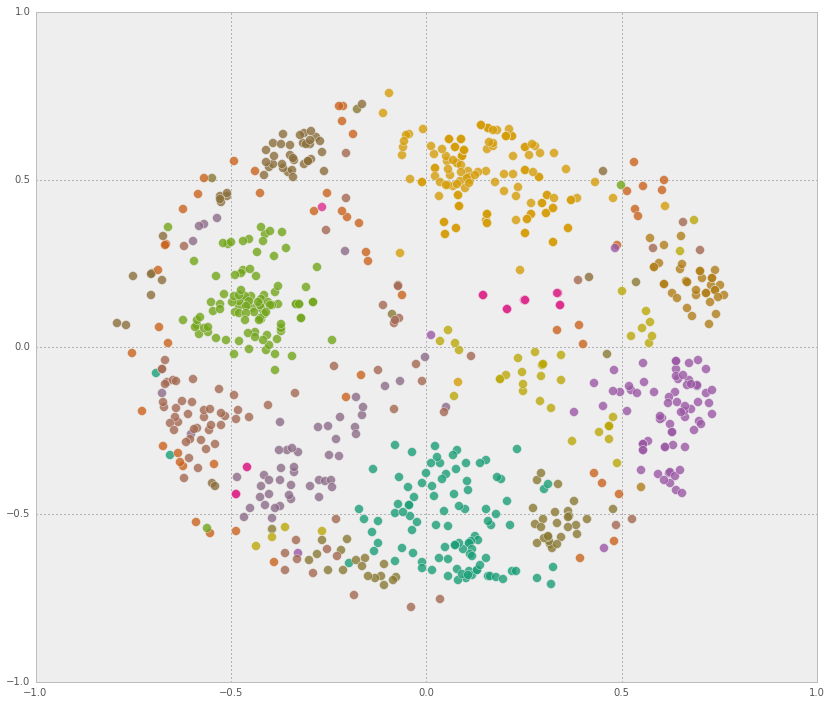

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(14.0, 12.0)
#colors = cycle('bgrcmykwbgrcmykbgrcmykwbgrcmykw')
colors = cycle(cm.Dark2(np.linspace(0,1,13)))
for name, group in dff.groupby('SCPN'):
    labels = []
    for i in group.index:
        zz = group.ix[[i],['SCPN','chemical_id','base64smi']]
        zz['mol'] = zz['base64smi'].map(lambda x: '<img src="http://{0}/utils/smiles2image/{1}?size=300" >'.format(base_url,x))
        del zz['base64smi']
        label = zz.T
        del zz
        label.columns = ['Row: {}'.format(i)]
        labels.append(str(label.to_html()))
    #labels.append(str(label.to_html()))
    points = ax.scatter(group['X'], group['Y'],c=colors.next(), s=80, alpha=0.8)
    tooltip = mpld3.plugins.PointHTMLTooltip(points, labels, voffset=10, hoffset=10, css=csss)
    mpld3.plugins.connect(fig,tooltip)                                          

Compounds in the same region of space come from the same patent document - that means that the MDS makes some sense. Plus we get [Beaker](https://www.ebi.ac.uk/chembl/api/utils/docs) structure renderings on the fly.

## 3. Define the MCS for each patent

A couple of helper functions, inspired by Greg Landrum's post [here](http://rdkit.blogspot.co.uk/2015/05/a-set-of-scaffolds-from-chembl-papers.html).

In [47]:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,350),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    
    rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    # the MolDraw2D code is not very good at the moment at dealing with atom queries,
    # this is a workaround until that's fixed.
    # The rendering is still not going to be perfect because query bonds are not properly indicated
    opts = drawer.drawOptions()
    for atom in mc.GetAtoms():
        if atom.HasQuery() and atom.DescribeQuery().find('AtomAtomicNum')!=0:
            opts.atomLabels[atom.GetIdx()]=atom.GetSmarts()
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [48]:
def MCS_Report(ms,atomCompare=MCS.AtomCompare.CompareAny,**kwargs):
    mcs = MCS.FindMCS(ms,atomCompare=atomCompare,timeout=120,**kwargs)
    nAts = np.array([x.GetNumAtoms() for x in ms])
    print 'Mean nAts: {0}, mcs nAts: {1}'.format(nAts.mean(),mcs.numAtoms)
    print 'MCS SMARTS: {0}'.format(mcs.smartsString)
    mcsM = Chem.MolFromSmarts(mcs.smartsString)
    
    mcsM.UpdatePropertyCache(False)
    Chem.SetHybridization(mcsM)
    Chem.Compute2DCoords(mcsM)
    smi = Chem.MolToSmiles(mcsM,isomericSmiles=True)
    print "MCS SMILES: {0}".format(smi)
    img=Draw.MolToImage(mcsM,kekulize=False)
    return mcs.smartsString,smi,img,mcsM

Add Murcko scaffolds in the frame, just in case we need them.

,ROMol,MurMol
17,,
18,,
19,,
20,,
21,,

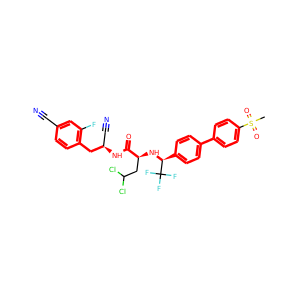
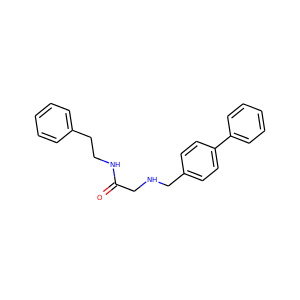
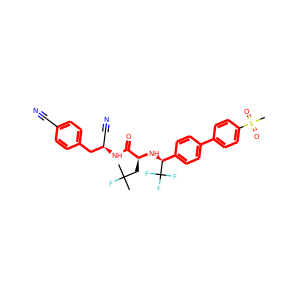
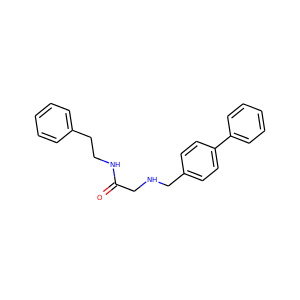
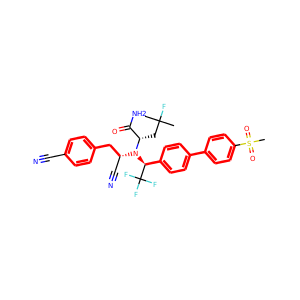
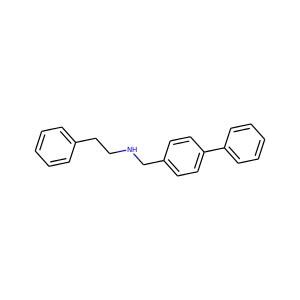
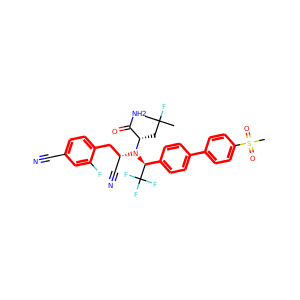
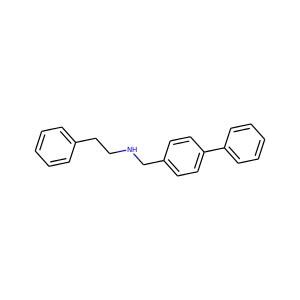
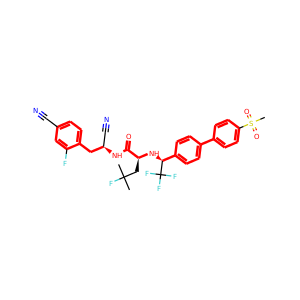
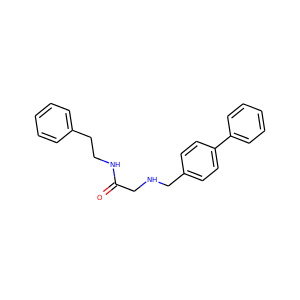

In [49]:
PandasTools.AddMurckoToFrame(dff)
PandasTools.AddMoleculeColumnToFrame(dff,smilesCol='Murcko_SMILES', molCol='MurMol')
PandasTools.AlignToScaffold(dff)
dff[['ROMol','MurMol']].head()

Let's now visualise the extracted compounds for a single patent, say US20100056494A1:

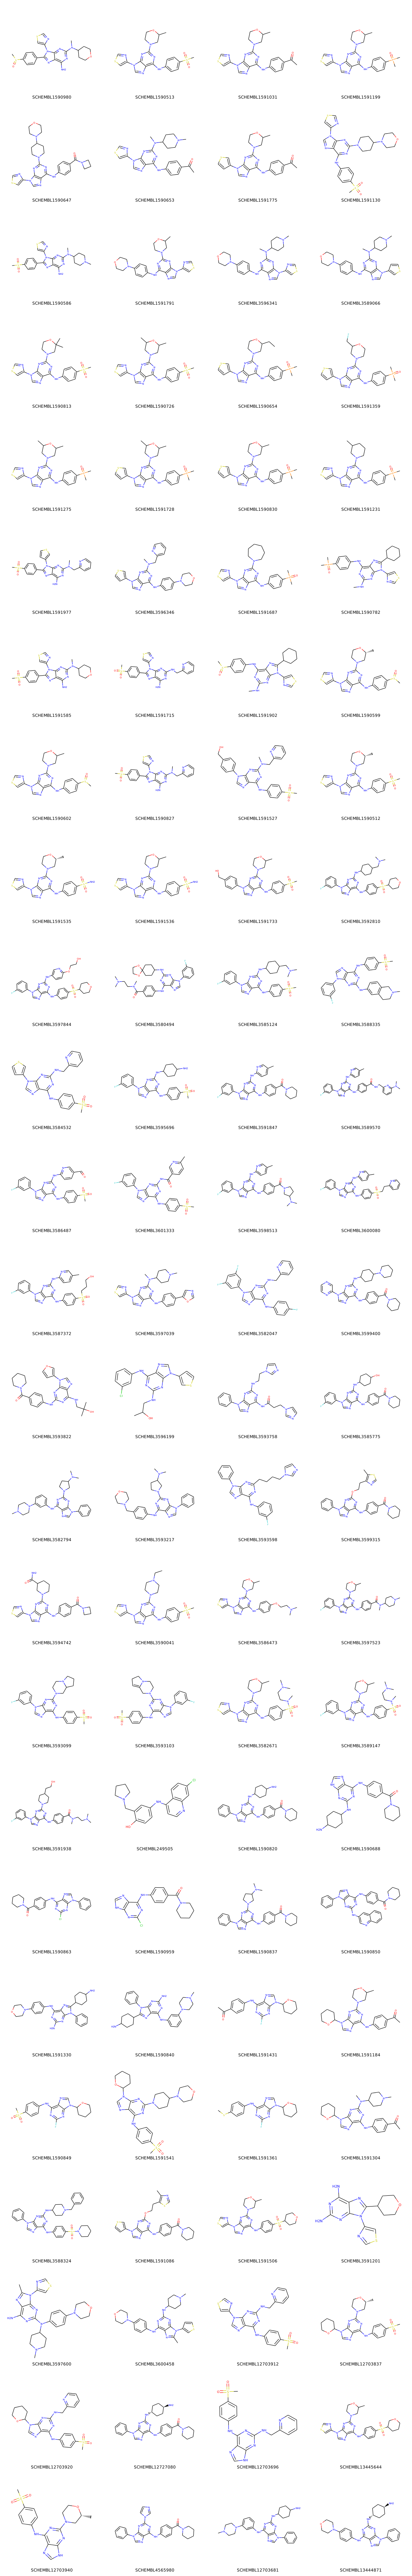

In [50]:
PandasTools.FrameToGridImage(dff.ix[dff['SCPN'] == 'US-20100056494-A1'],legendsCol='chemical_id', molsPerRow=4, subImgSize=(300, 300))

OK, the structures seem consistent with a well defined MCS. Let's see if that's the case for two thresholds

Mean nAts: 34.79, mcs nAts: 26
MCS SMARTS: [#6,#7]-[#6,#15,#16](=[#8])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6](:[#6](:[#7,#6]:[#6,#7]:[#7,#6]-[#6,#7]1-,:[#6,#7]-,:[#6]-,:[#6,#7,#8]-,:[#6,#7]-,:[#8,#6]-,:1):[#6,#7]:[#7,#6]:[#6,#7]-[#9,#6,#7,#8,#17]):[#7]
MCS SMILES: CC(=O)C1:C:C:C(NC(:N):C(:C:N:CF):N:C:NC2CCCCO2):C:C:1


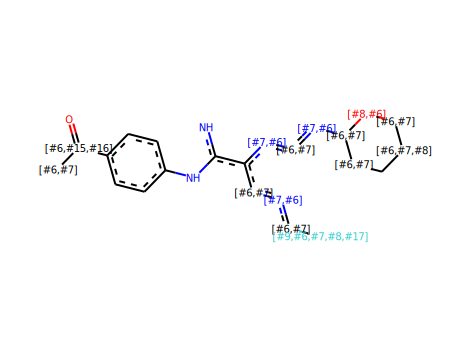

In [51]:
mols = list(dff.ix[dff['SCPN'] == 'US-20100056494-A1'].ROMol)
smarts,smi,img,mcsM = MCS_Report(mols,threshold=0.6,ringMatchesRingOnly=True)
SVG(moltosvg(mcsM))

Mean nAts: 34.79, mcs nAts: 23
MCS SMARTS: [#16,#6,#7,#8,#9,#15]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6]1:[#6]2:[#7]:[#6]:[#7](:[#6]:2:[#7]:[#6](:[#7]:1)-[#9,#7,#8,#17])-[#6](-,:[#6,#7]-,:[#6,#16])-,:[#8,#6,#7]-,:[#6,#7]
MCS SMILES: CCC(OC)N1:C:N:C2:C(NC3:C:C:C(S):C:C:3):N:C(F):N:C:2:1


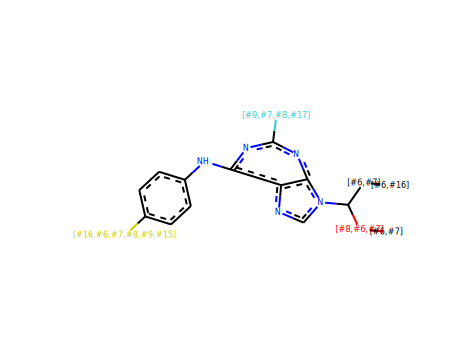

In [52]:
smarts,smi,img,mcsM = MCS_Report(mols,threshold=0.8,ringMatchesRingOnly=True)
SVG(moltosvg(mcsM))

So, the higher the threshold, the more generic the MCS. But is the MCS similar to the claimed Markush structure?
Let's fetch the original document in PDF and check in page 2: (**NB:** The link below is external.)

In [53]:
HTML('<iframe src=https://dl.dropboxusercontent.com/u/22273283/US20100056494A1.pdf width=1000 height=500></iframe>')

Pretty close! Now let's do the same thing for all the patents:

In [54]:
smartss = []
smis = []
imgs = []
patents = []
mcss = []

In [55]:
for patent, group in dff.groupby('SCPN'):
    mols = list(group['ROMol'])
    print "Patent: {0}".format(patent)
    smarts,smi,img,mcs = MCS_Report(mols,threshold=0.8,ringMatchesRingOnly=True)
    smartss.append(smarts)
    smis.append(smi)
    imgs.append(img)
    patents.append(patent)
    mcss.append(mcs)

Patent: US-20100056494-A1
Mean nAts: 34.79, mcs nAts: 23
MCS SMARTS: [#16,#6,#7,#8,#9,#15]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6]1:[#6]2:[#7]:[#6]:[#7](:[#6]:2:[#7]:[#6](:[#7]:1)-[#9,#7,#8,#17])-[#6](-,:[#6,#7]-,:[#6,#16])-,:[#8,#6,#7]-,:[#6,#7]
MCS SMILES: CCC(OC)N1:C:N:C2:C(NC3:C:C:C(S):C:C:3):N:C(F):N:C:2:1
Patent: US-20100069428-A1
Mean nAts: 27.3529411765, mcs nAts: 18
MCS SMARTS: [#6,#7]-[#6,#7]-[#6]-[#6,#8]-[#7,#6]1:[#6]:[#6]:[#6,#7,#8]:,-[#6,#7]:,-[#6,#7]:[#6]:[#6]:[#6]:[#6]:[#6,#7]:,-[#6,#7]:,-[#6]:[#6]:1
MCS SMILES: CCCCN1:C:C:C:C:C:C:C:C:C:C:C:C:C:1
Patent: US-20100081665-A1
Mean nAts: 29.9615384615, mcs nAts: 8
MCS SMARTS: [#35,#6,#7,#8,#9]-[#6,#7,#8,#16]-[#6]1:[#6]:[#6,#7]:[#6]:[#6,#7]:[#6]:1
MCS SMILES: BrCC1:C:C:C:C:C:1
Patent: US-20100093726-A1
Mean nAts: 26.25, mcs nAts: 19
MCS SMARTS: [#6]1:,-[#6,#7,#8]:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-1)-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7,#6](-,:[#6]-,:[#6])-,:[#6]-,:[#6,#7]
MCS SMILES: CCN(CC)CC1:C:C:C(CC2:C:C:C

Tidy up this info in a data frame:

In [56]:
dd = pd.DataFrame(zip(patents,smartss,smis),columns=['SCPN','MCS_SMARTS','MCS_SMILES'])
dd.set_index('SCPN', inplace=True)
dd

,MCS_SMARTS,MCS_SMILES
SCPN,,
US-20100056494-A1,"[#16,#6,#7,#8,#9,#15]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6]1:[#6]2:[#7]:[#6]:[#7](:[#6]:2:[#7]:[#6](:[#7]:1)-[#9,#7,#8,#17])-[#6](-,:[#6,#7]-,:[#6,#16])-,:[#8,#6,#7]-,:[#6,#7]",CCC(OC)N1:C:N:C2:C(NC3:C:C:C(S):C:C:3):N:C(F):N:C:2:1
US-20100069428-A1,"[#6,#7]-[#6,#7]-[#6]-[#6,#8]-[#7,#6]1:[#6]:[#6]:[#6,#7,#8]:,-[#6,#7]:,-[#6,#7]:[#6]:[#6]:[#6]:[#6]:[#6,#7]:,-[#6,#7]:,-[#6]:[#6]:1",CCCCN1:C:C:C:C:C:C:C:C:C:C:C:C:C:1
US-20100081665-A1,"[#35,#6,#7,#8,#9]-[#6,#7,#8,#16]-[#6]1:[#6]:[#6,#7]:[#6]:[#6,#7]:[#6]:1",BrCC1:C:C:C:C:C:1
US-20100093726-A1,"[#6]1:,-[#6,#7,#8]:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-1)-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7,#6](-,:[#6]-,:[#6])-,:[#6]-,:[#6,#7]",CCN(CC)CC1:C:C:C(CC2:C:C:C:C:C:2):C:C:1
US-20100113436-A1,"[#16,#6,#7]-[#6,#16]-[#6,#7]1-[#6]-[#6]-[#6]2(-[#6]-[#6]-1)-[#8,#6]-[#8]-[#6](-[#8]-[#8]-2)(-[#6]-[#6]-[#6])-[#6]-[#6]",CCCC1(CC)OOC2(CCC(CS)CC2)OO1
US-20100190848-A1,"[#6,#8]=[#6]-[#6,#7]-[#6](-[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6,#7,#8]-[#8,#6,#7,#14]",C=CCC(CO)CCC1:C:C:C:C:C:1
US-20100196502-A1,"[#6,#1,#7,#8]-[#6,#7,#8,#16]-[#7,#6]-[#6,#7](:,-[#6,#7,#16]:,-[#6,#7]):,-[#6,#7,#16]:,-[#6,#7]",C:C:C(:C:C)NCC
US-20100197640-A1,"[#7,#6]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#6]",CC1:C:C:C:C(NC(=O)NC2:C:C:C(S(N)(=O)=O):C:C:2):C:1
US-20100298422-A1,"[#8,#6,#7]-[#6,#8]-[#6,#8]-[#6]1-,:[#16,#6]-,:[#6]-,:[#6,#8]-,:[#6]-,:[#16,#6,#8]-,:1",OCCC1SCCCS1


Visualise the MCS per patent document:

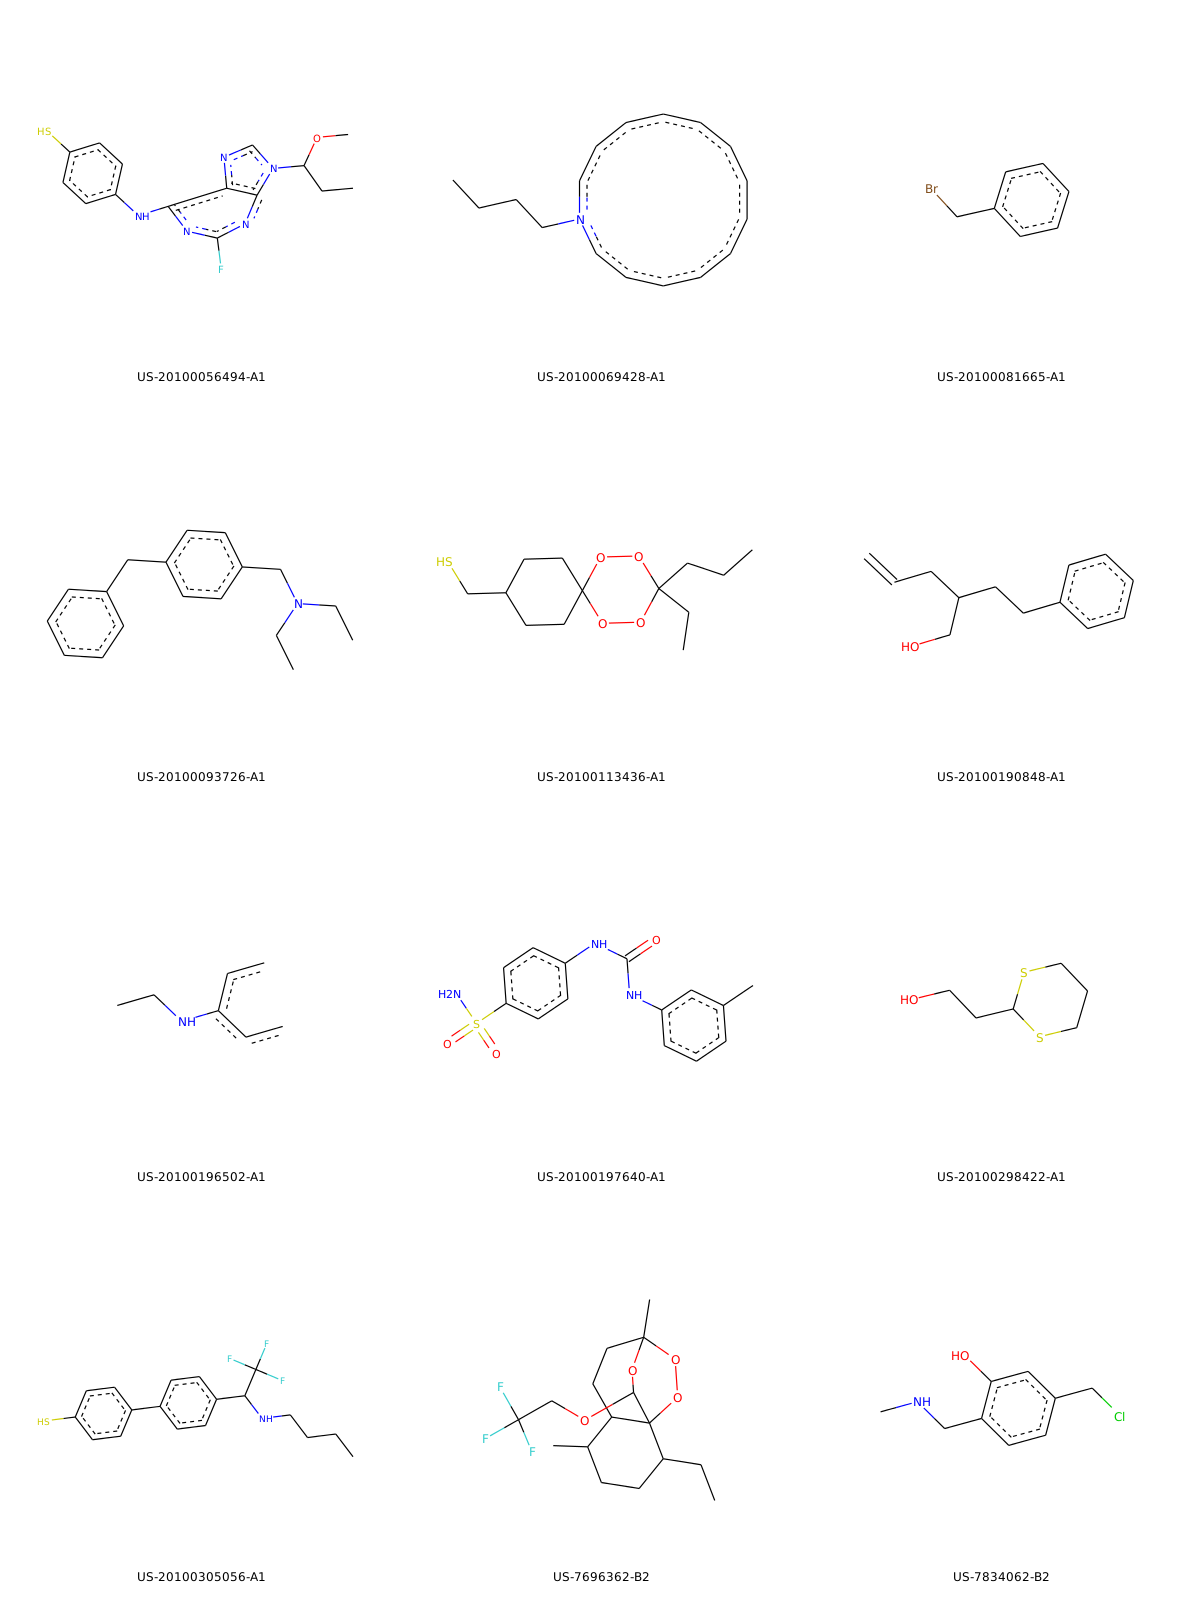

In [57]:
Draw.MolsToGridImage(mcss,legends=patents, molsPerRow=3, subImgSize=(400, 400),kekulize=False)

The previous summary table was:

In [58]:
dff_counts #NB: The links in this table are external.

,# Compounds,Link
SCPN,,
US-20100056494-A1,100,US-20100056494-A1
US-20100069428-A1,51,US-20100069428-A1
US-20100081665-A1,52,US-20100081665-A1
US-20100093726-A1,52,US-20100093726-A1
US-20100113436-A1,74,US-20100113436-A1
US-20100190848-A1,26,US-20100190848-A1
US-20100196502-A1,77,US-20100196502-A1
US-20100197640-A1,102,US-20100197640-A1
US-20100298422-A1,42,US-20100298422-A1


Finally, merge the two frames together

In [59]:
pd.merge(dd, dff_counts, left_index=True, right_index=True)

,MCS_SMARTS,MCS_SMILES,# Compounds,Link
SCPN,,,,
US-20100056494-A1,"[#16,#6,#7,#8,#9,#15]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6]1:[#6]2:[#7]:[#6]:[#7](:[#6]:2:[#7]:[#6](:[#7]:1)-[#9,#7,#8,#17])-[#6](-,:[#6,#7]-,:[#6,#16])-,:[#8,#6,#7]-,:[#6,#7]",CCC(OC)N1:C:N:C2:C(NC3:C:C:C(S):C:C:3):N:C(F):N:C:2:1,100,US-20100056494-A1
US-20100069428-A1,"[#6,#7]-[#6,#7]-[#6]-[#6,#8]-[#7,#6]1:[#6]:[#6]:[#6,#7,#8]:,-[#6,#7]:,-[#6,#7]:[#6]:[#6]:[#6]:[#6]:[#6,#7]:,-[#6,#7]:,-[#6]:[#6]:1",CCCCN1:C:C:C:C:C:C:C:C:C:C:C:C:C:1,51,US-20100069428-A1
US-20100081665-A1,"[#35,#6,#7,#8,#9]-[#6,#7,#8,#16]-[#6]1:[#6]:[#6,#7]:[#6]:[#6,#7]:[#6]:1",BrCC1:C:C:C:C:C:1,52,US-20100081665-A1
US-20100093726-A1,"[#6]1:,-[#6,#7,#8]:,-[#6]:,-[#6]:,-[#6,#7](:,-[#6]:,-1)-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7,#6](-,:[#6]-,:[#6])-,:[#6]-,:[#6,#7]",CCN(CC)CC1:C:C:C(CC2:C:C:C:C:C:2):C:C:1,52,US-20100093726-A1
US-20100113436-A1,"[#16,#6,#7]-[#6,#16]-[#6,#7]1-[#6]-[#6]-[#6]2(-[#6]-[#6]-1)-[#8,#6]-[#8]-[#6](-[#8]-[#8]-2)(-[#6]-[#6]-[#6])-[#6]-[#6]",CCCC1(CC)OOC2(CCC(CS)CC2)OO1,74,US-20100113436-A1
US-20100190848-A1,"[#6,#8]=[#6]-[#6,#7]-[#6](-[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6,#7,#8]-[#8,#6,#7,#14]",C=CCC(CO)CCC1:C:C:C:C:C:1,26,US-20100190848-A1
US-20100196502-A1,"[#6,#1,#7,#8]-[#6,#7,#8,#16]-[#7,#6]-[#6,#7](:,-[#6,#7,#16]:,-[#6,#7]):,-[#6,#7,#16]:,-[#6,#7]",C:C:C(:C:C)NCC,77,US-20100196502-A1
US-20100197640-A1,"[#7,#6]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#6]",CC1:C:C:C:C(NC(=O)NC2:C:C:C(S(N)(=O)=O):C:C:2):C:1,102,US-20100197640-A1
US-20100298422-A1,"[#8,#6,#7]-[#6,#8]-[#6,#8]-[#6]1-,:[#16,#6]-,:[#6]-,:[#6,#8]-,:[#6]-,:[#16,#6,#8]-,:1",OCCC1SCCCS1,42,US-20100298422-A1
